In [1]:
# Read data

import numpy as np  
import tifffile  
import matplotlib.pyplot as plt  

# Read a multi-frame TIFF image using tifffile and load it as a NumPy array
stack = tifffile.imread(r"D:\Work\Code\Python\Drawing\simulation\\exp\speed\d=16_v=1500_f=50_simu.tif")

# Convert the image data to a boolean array (True/False)
# Non-zero pixel values are treated as True, and zero values are treated as False
mat = np.array(stack).astype(bool)

# Print the shape of the TIFF stack
# The output will usually show (number_of_frames, height, width)
print(stack.shape)



(40000, 250, 400)


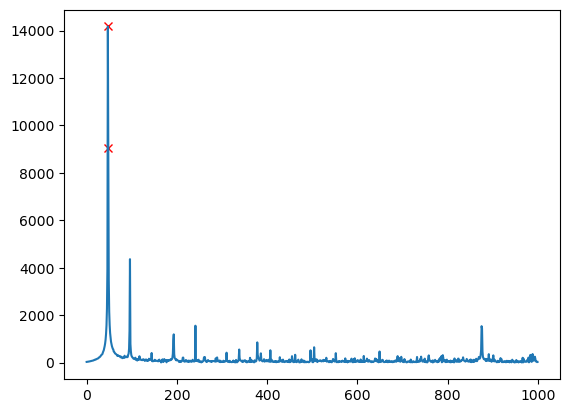

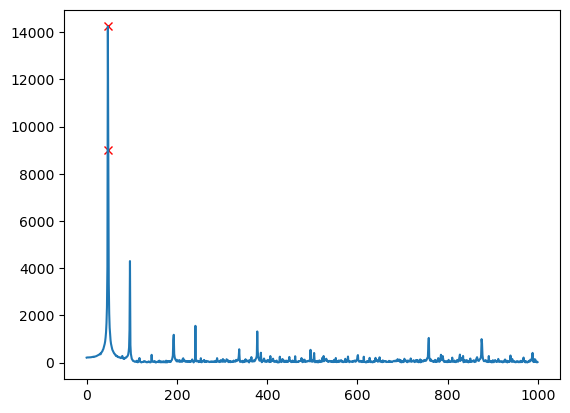

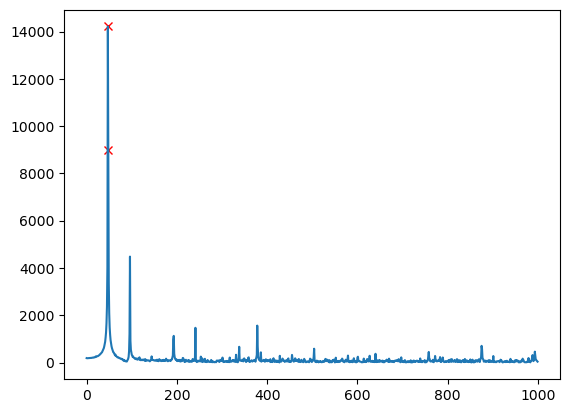

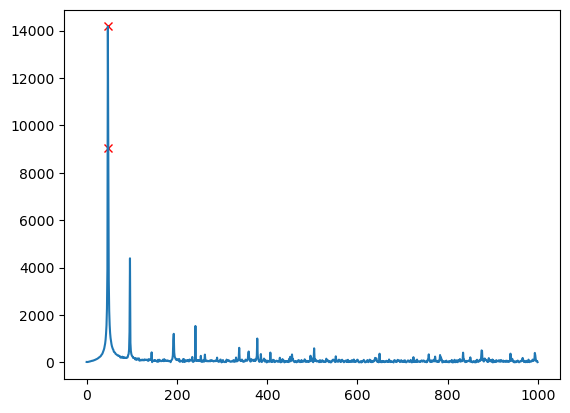

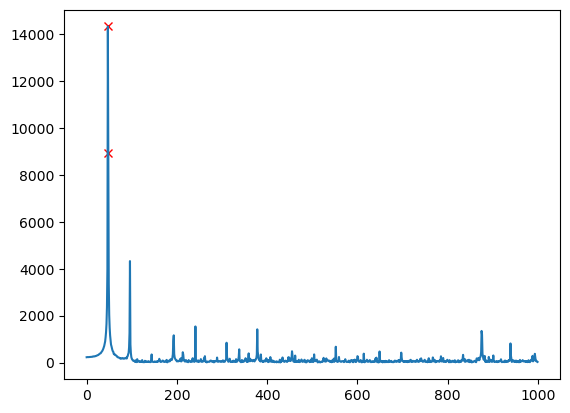

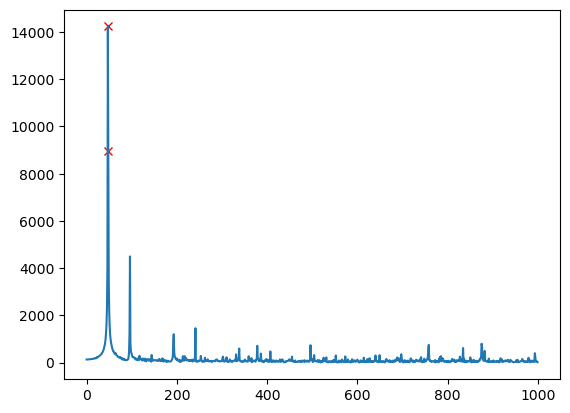

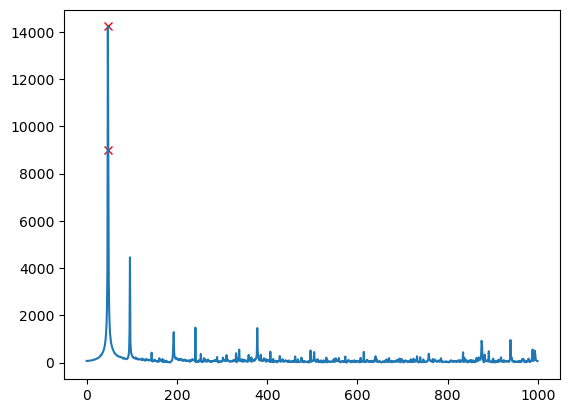

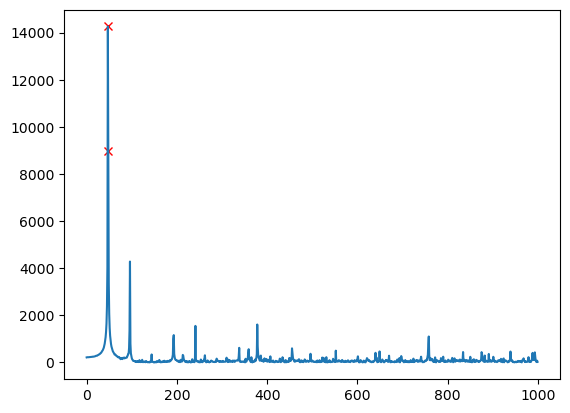

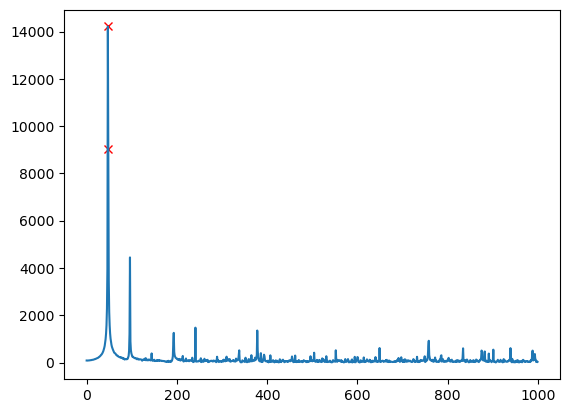

Optimal parameters not found. Fit skipped.


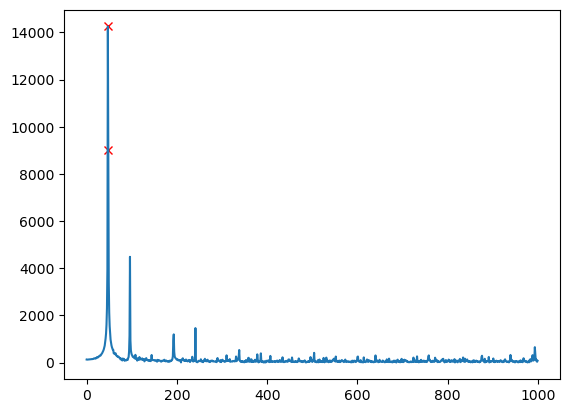

avg_freq_time: 0.013088726997375488
[48. 48. 48. 48. 48. 48. 48. 48. 48. 48.]
48.0


In [2]:
#  calculate frequency with multi columns

import math
import matplotlib.pyplot as plt
import openpyxl
from scipy.optimize import curve_fit
from openpyxl.drawing.image import Image
from scipy.signal import find_peaks
import scipy
import time


total_freq_time = 0
total_speed_time = 0

window_size = 1
frame_size = 20000  

start_frame = 0

# Parameters for spatial windowing (height and length of the region of interest)
x_window_size = 135 # Height of the window (in pixels)
xl = 115 # Starting x-coordinate of the window
xh = xl + x_window_size

# Width of the window (in pixels)
y_window_size =10

# Frequency-related parameters
# freq_n = int(2e4)
freq_value = []
for y in range(300, 400, 10):
    f_start_time = time.time()
    y_left = y
    y_right = y_left + y_window_size

    data = mat[start_frame:start_frame+frame_size, xl:xh, y_left:y_right].sum(axis=(1, 2)).reshape(-1, window_size).sum(axis=1)
    
    data_rfft = np.fft.rfft(data)
    freq = np.fft.rfftfreq(data.shape[-1], d=1./2e4)
    data_rfft_amp = np.abs(data_rfft)[1:]
    freq = freq[1:]

    highest_freq = 1e3
    highest_index = math.ceil(freq.shape[-1]*highest_freq/1e4) 

    low = data_rfft_amp[:highest_index]  
    index = low.argsort()

     
    low_index = index[-1]
    if low_index == 0:
        continue
    record_peaks = [low_index]
    for i in range(-5,-1):
        possible_peak = index[i]
        if data_rfft_amp[possible_peak]>data_rfft_amp[low_index]*0.5:
            record_peaks.append(possible_peak)
    record_peaks.sort()
    low_index = record_peaks[0]

    plt.plot(record_peaks, data_rfft_amp[:highest_index][record_peaks], "xr")
    plt.plot(data_rfft_amp[:highest_index])
    # plt.plot(data_rfft_amp)
    plt.show()
    def gaussian(x, amplitude, mean, stddev):
        return amplitude * np.exp(-((x - mean) / stddev) ** 2 / 2)
    interval = 50
    if (low_index < interval ):
        interval = low_index-1
    interval = int(interval)
    np.std(data_rfft_amp[low_index-interval:low_index+interval])
    # Attempt Gaussian fitting
    initial_guess = [data_rfft_amp[low_index], low_index,  np.std(data_rfft_amp[low_index-interval:low_index+interval])]     
    try:
            popt, _= curve_fit(gaussian, freq[low_index-interval:low_index+interval], data_rfft_amp[low_index-interval:low_index+interval],p0=initial_guess)
    except:
        print("Optimal parameters not found. Fit skipped.") 
        freq_value.append(freq[low_index])
    else:
        amplitude_fit, mean_fit, stddev_fit = popt 
        if(mean_fit < 0 or abs(mean_fit - freq[low_index]) > 20):
            if (low_index < 100):
                freq_value.append(freq[low_index])
            continue  
        else:
            freq_value.append(mean_fit) 
    f_end_time = time.time()
    every_freq_time = f_end_time - f_start_time
    total_freq_time += every_freq_time
avg_freq_time = total_freq_time / 10
time1 = time.time()
print("avg_freq_time:",avg_freq_time)
freq_value = np.array(freq_value)
print(freq_value)
if np.size(freq_value)>0:
    freq_max = np.max(freq_value)
    freq_min = np.min(freq_value)
    if(abs(freq_max/freq_min - round(freq_max/freq_min)) < 0.1):   
        freq_value = freq_min
    
print(np.average(freq_value))
time2=time.time()




In [3]:
# calculate speed


# Initialize parameters
window_size = 1
step_size = 100  # Step size for sliding window
frame_size = 20000 # Size of data frame for FFT

start_frame = 0  # Starting frame for calculations

y_left_ref = 250 # Starting y-coordinate of the reference window
y_right_ref = y_left_ref + y_window_size    # Ending y-coordinate of the reference window

highest_freq = 1e3 # Highest frequency to consider for calculations

space = 5 # Space around the peak to be removed

y_left = 245   # Starting y-coordinate of the sliding window
y_right = y_left + y_window_size    # Ending y-coordinate of the sliding window


freq_n = frame_size # FFT frequency resolution
count=0
cos_pulse = []
for start in range(0, mat.shape[0]-frame_size-step_size, step_size):
    count+=1
    s_start_time = time.time()
    # Process reference line data
    y_ref_data = mat[start:start+frame_size, xl:xh, y_left_ref:y_right_ref].sum(axis=(1, 2)).reshape(-1, window_size).sum(axis=1)
    y_ref_data_rfft = np.fft.rfft(y_ref_data, freq_n)
    y_ref_freq = np.fft.rfftfreq(freq_n, d=1./2e4)
    y_ref_data_rfft_amp = np.abs(y_ref_data_rfft)[1:]

    highest_index = math.ceil(y_ref_freq.shape[-1]*highest_freq/1.e4)

    y_ref_low = y_ref_data_rfft_amp[:highest_index]
    y_ref_index = y_ref_low.argsort()
    # y_ref_low_index = y_ref_index[-1]
    y_ref_low_index = low_index
    
    # y_ref_low_index = np.where(y_ref_freq>mean_fit)[0]
    y_ref_data_rfft.real[y_ref_low_index+space:] = 0
    y_ref_data_rfft.imag[y_ref_low_index+space:] = 0
    y_ref_data_rfft.real[:y_ref_low_index-space] = 0
    y_ref_data_rfft.imag[:y_ref_low_index-space] = 0
    
    y_ref_filter_data = np.fft.irfft(y_ref_data_rfft, freq_n)
    y_ref_filter_data_rfft = np.fft.rfft(y_ref_filter_data, freq_n)
    
    # Process sliding line data
    data = mat[start:start+frame_size, xl:xh, y_left:y_right].sum(axis=(1, 2)).reshape(-1, window_size).sum(axis=1)
    data_rfft = np.fft.rfft(data, freq_n)
    freq = np.fft.rfftfreq(freq_n, d=1./2e4)
    data_rfft_amp = np.abs(data_rfft)[1:]

    highest_index = math.ceil(freq.shape[-1]*highest_freq/1.e4)

    low = np.abs(data_rfft_amp[:highest_index])
    index = low.argsort()
    low_index = low_index
    
    # main_peaks = np.where((np.abs(low) > data_rfft_amp[low_index]*0.1))[0]
    # low_index = (main_peaks[0])
    
    data_rfft.real[low_index+space:] = 0
    data_rfft.imag[low_index+space:] = 0
    data_rfft.real[:low_index-space] = 0
    data_rfft.imag[:low_index-space] = 0
    
    filter_data = np.fft.irfft(data_rfft, freq_n)
    filter_data_rfft = np.fft.rfft(filter_data, freq_n)
    
    data_multiply = np.multiply(y_ref_filter_data, filter_data).sum(axis=0) 
    rfft_multiply_amp = (4*np.abs(y_ref_filter_data_rfft)[0:]*np.abs(filter_data_rfft)[0:]/frame_size/frame_size).sum(axis=0)
    cos_x = 2*data_multiply/rfft_multiply_amp/frame_size
    cos_pulse.append(math.acos(cos_x)) 
    s_end_time = time.time()
    every_speed_time = s_end_time - s_start_time
    total_speed_time += every_speed_time  

time3=time.time()
print(cos_pulse)
print(np.mean(cos_pulse), np.var(cos_pulse))
avg_speed_time = total_speed_time / count
print("avg_speed_time:",avg_speed_time)

theta = np.mean(cos_pulse)
freq = np.median(freq_value)
delta_t = theta/2/math.pi/freq
delta_d = y_left_ref - y_left
speed = delta_d/delta_t
print(freq, delta_t, delta_d, speed) 
time4=time.time()


[1.0111364899459945, 1.0174259124502896, 1.0110895801828952, 1.016628554941077, 1.0114926724325102, 1.0176874701543182, 1.0111509528614837, 1.0176716439752453, 1.011867000688302, 1.0174493798669422, 1.0110305726526636, 1.0192893824998273, 1.0119662958485827, 1.0169342408565132, 1.0126584202454447, 1.0182627147803462, 1.0125948860132334, 1.0154323972333505, 1.013810580769418, 1.0164131498926332, 1.0135529232536291, 1.0145559659202683, 1.015708765886531, 1.0162184284126512, 1.0146045088475895, 1.014440980704081, 1.0176362671943184, 1.0144842584547853, 1.0161269011943896, 1.012865616025304, 1.0196090626480685, 1.012522136977888, 1.0175593331481632, 1.0128987065840842, 1.018813967719231, 1.0125003268212585, 1.0184048058953132, 1.0125395030535225, 1.018967822649775, 1.0117587673232875, 1.0195118304519712, 1.012274916369788, 1.0190907737481338, 1.0131436068897632, 1.0193882746602914, 1.0125148792854526, 1.016682763780939, 1.0145670688659705, 1.0178529772991969, 1.0139302625084492, 1.01554037

In [7]:
    #calculate size

window_size = 1

start_frame = 0  # Starting frame for calculations    
step_size = 5000 # Step size for sliding window in the time domain


from collections import Counter
# Containers for storing results
s1 = []
s2 = []
s3 = []
frame_size = 5000 # Size of each data frame for processing
for start in range(0, mat.shape[0]-frame_size-step_size, step_size):  
    all_d = []
    for i in range(400):
        a = 125
        b = i
        y = mat[:, a:a+1, b:b+1].sum(axis=(1, 2)).reshape(-1, window_size).sum(axis=1)[start:start+frame_size]
        y_spike = np.where(y == 1)[0]
        y_spike = np.array(y_spike)
        y_diff = y_spike[1:] - y_spike[:-1]
        # y_diff_mean = math.ceil(np.mean(y_diff))
        y_diff_mean = np.mean(y_diff)
        y_diff_d = np.where(y_diff >y_diff_mean)
        d = y_spike[y_diff_d[:]]
        d = d[1:] - d[:-1]
        all_d.append(d)
    all_d = [item for sublist in all_d for item in sublist]
    all_d = np.array(all_d)
    element_counts = Counter(all_d).most_common()
    
    
    def merge_element_counts(element_counts,offset):
        sorted_counts = sorted(element_counts, key=lambda x: -x[1])
        merged_counts = []
        while sorted_counts:
            current = sorted_counts.pop(0)
            to_merge = [current]
            
            
            i = 0
            while i < len(sorted_counts):
                if abs(current[0] - sorted_counts[i][0]) <= offset:
                    to_merge.append(sorted_counts.pop(i))
                else:
                    i += 1
            
            new_value = max(pair[0] for pair in to_merge)
            new_count = sum(pair[1] for pair in to_merge)
            merged_counts.append((new_value, new_count))
        merged_counts = sorted(merged_counts, key=lambda x: -x[1]) 
        return merged_counts
    
    merged_counts = merge_element_counts(element_counts,15)
    labels, counts = zip(*merged_counts)
    # print(labels)
    # print(counts)
    # speed = 2000 # use pre-computed speed
    size = labels[0]*speed*22 / 20000 # 22um for pixel size, 20000 for frame rate.
    velocity = speed * 0.022
print("droplet frequency:",freq,"(Hz)")
print("droplet velocity:",velocity,"(mm/s)")
print("droplet size:",size,"(um)")


droplet frequency: 48.0 (Hz)
droplet velocity: 32.636986405287246 (mm/s)
droplet size: 344.3202065757804 (um)
